# Propensity Scoring

From [http://openonlinecourses.com/causalanalysis/Propensity%20Scoring.asp](http://openonlinecourses.com/causalanalysis/Propensity%20Scoring.asp).

## Question 1

In [1]:
import pandas as pd

df = pd.read_excel('Expected LOS in 10 Diseases.xlsx')
df.shape

(6657, 11)

Balance the data by propensity to seek care from Dr. Smith.  This involve first predicting probability of a patient type utilizing services of Dr. Smith; then weighting the data inversely proportional to the probability of using Dr. Smith.  Note that patients cared for by Dr. Smith and by his peer group will have a different set of weights.  The net results of weights is that patients cared for by Dr. Smith and his peer will have the same rate of various diseases.

In [2]:
X = df.dropna()
X, y = X[[c for c in X.columns if c not in ['Cared for by Dr Smith', 'LOS']]], X['Cared for by Dr Smith']

X.shape, y.shape

((6657, 9), (6657,))

In [3]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=10_000)
model.fit(X, y)

model.intercept_[0], model.coef_[0]

(0.8773204607812382,
 array([ 0.00411923, -0.0091996 , -0.00089115,  0.01316132,  0.01316132,
        -0.0143746 , -0.08469029, -0.52473351, -0.52473351]))

In [4]:
y_pred = model.predict_proba(X)[:,1]
y_pred.shape

(6657,)

In [5]:
Y = pd.DataFrame({'y_true': y, 'y_pred': y_pred})
Y_1 = Y[Y['y_true'] == 1][['y_pred']]
Y_0 = Y[Y['y_true'] == 0][['y_pred']]

Y.shape, Y_1.shape, Y_0.shape

((6657, 2), (4007, 1), (2650, 1))

In [6]:
from sklearn.neighbors import NearestNeighbors

nn = NearestNeighbors()
nn.fit(Y_1)

NearestNeighbors()

In [7]:
def get_y0_iloc(i):
    return Y_0.iloc[i:i+1].index[0]

def get_y1_iloc(i):
    return Y_1.iloc[i:i+1].index[0]

def get_y1_ilocs(indices):
    return [get_y1_iloc(i) for i in indices]
    
neighbors = nn.kneighbors(Y_0, return_distance=False)
seen = {}
pairs = []
for i, neighs in enumerate(neighbors):
    y_0 = get_y0_iloc(i)
    ilocs = [j for j in get_y1_ilocs(neighs) if j not in seen]
    if len(ilocs) > 0:
        y_1 = ilocs[0]
    else:
        y_1 = get_y1_ilocs(neighs)[0]
    tup = y_0, y_1
    pairs.append(tup)
    
pair_df = pd.DataFrame(pairs, columns=['y_0', 'y_1'])
pair_df.shape

(2650, 2)

In [8]:
X.iloc[pair_df['y_0']].mean()

Hypertension             0.500000
Anemia                   0.499623
Diabetes                 0.499623
HIV                      0.498868
Stomach Cancer           0.498868
Lung Cancer              0.495094
Myocardial Infarction    0.492830
Heart Failure            0.483019
Metastetic Cancer        0.483019
dtype: float64

In [9]:
X.iloc[pair_df['y_1']].mean()

Hypertension             0.500000
Anemia                   0.499623
Diabetes                 0.499623
HIV                      0.497358
Stomach Cancer           0.500377
Lung Cancer              0.495094
Myocardial Infarction    0.492830
Heart Failure            0.477358
Metastetic Cancer        0.488679
dtype: float64

### (a) Graphically show that the weighting procedure you followed results in same set of patients treated by either Dr. Smith or his peer.

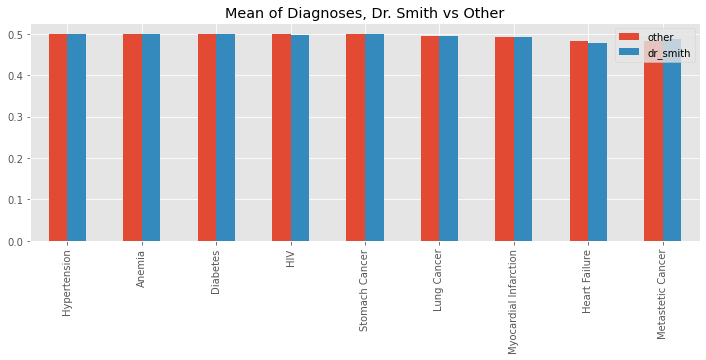

In [10]:
import matplotlib.pyplot as plt

plt.style.use('ggplot')

_ = pd.DataFrame({
    'other': X.iloc[pair_df['y_0']].mean(),
    'dr_smith': X.iloc[pair_df['y_1']].mean()
}).plot(kind='bar', figsize=(12, 4), title='Mean of Diagnoses, Dr. Smith vs Other')

### (b) Report the unconfounded impact of Dr. Smith on length of stay.

In [11]:
df.iloc[pair_df['y_0']]['LOS'].mean(), df.iloc[pair_df['y_1']]['LOS'].mean()

(3.960754716981132, 3.9381132075471696)

In [12]:
df.iloc[pair_df['y_1']]['LOS'].mean() - df.iloc[pair_df['y_0']]['LOS'].mean()

-0.02264150943396226

In [13]:
pair_df['y_0_LOS'] = pair_df['y_0'].apply(lambda i: df.iloc[i]['LOS'])
pair_df['y_1_LOS'] = pair_df['y_1'].apply(lambda i: df.iloc[i]['LOS'])
pair_df['diff'] = pair_df['y_1_LOS'] - pair_df['y_0_LOS']

pair_df

,y_0,y_1,y_0_LOS,y_1_LOS,diff
0,0,5406,3,4,1
1,1,5407,4,7,3
2,4,5408,3,2,-1
3,5,2055,6,6,0
4,8,1034,6,1,-5
...,...,...,...,...,...
2645,5289,6103,3,4,1
2646,5292,6653,6,2,-4
2647,5293,6646,5,2,-3
2648,5296,6228,5,1,-4


In [14]:
pair_df['diff'].mean()

-0.022641509433962263

## Question 2

In [15]:
df = pd.read_csv('StomachCancer.csv', index_col=0).reset_index(drop=True)
df.shape

(100000, 37)

In [16]:
df.head()

,Cancer,I305.1,I309.81,I311.,IE849.7,I150.9,I276.1,I276.8,I530.81,I263.9,...,I244.9,I414.01,I599.0,I414.00,I585.9,I600.00,I428.0,I427.31,I403.90,Dead
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


### 1. Using logistic regression, calculate the propensity to have cancer.  

In [17]:
X = df.dropna()
X, y = X[[c for c in X.columns if c not in ['Cancer', 'Dead']]], X['Cancer']

X.shape, y.shape

((100000, 35), (100000,))

In [18]:
model = LogisticRegression(max_iter=10_000)
model.fit(X, y)

model.intercept_[0], model.coef_[0]

(-6.352516774020059,
 array([-0.51379627, -0.99071863, -0.11565726,  0.51431978,  1.92861808,
        -0.50159173,  0.23416255,  0.30413644,  0.87534745,  0.40272049,
         0.18343113,  0.72823824,  0.10525224,  1.2438989 , -0.19073216,
        -0.32511728,  0.99409465, -0.0665818 , -0.01958849, -0.11171967,
        -0.6613992 , -0.15020208,  2.32804079,  0.89566458, -0.49826725,
         0.08052194,  0.1955976 ,  0.26834448, -0.4246738 ,  0.01381369,
         0.86250309,  0.01666058, -0.37410434,  0.44974668, -0.64256317]))

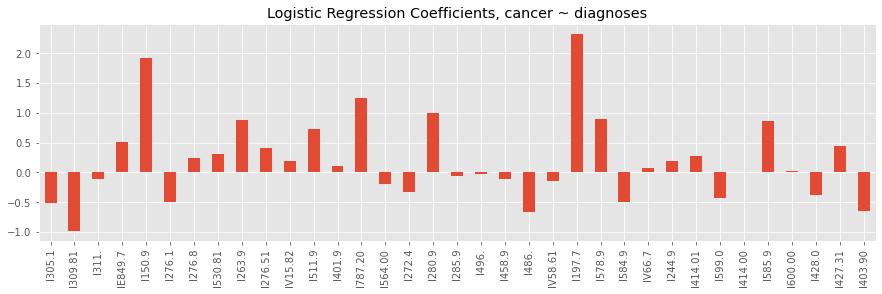

In [19]:
s1 = pd.Series(model.coef_[0], index=X.columns)
_ = s1.plot(kind='bar', figsize=(15, 4), title='Logistic Regression Coefficients, cancer ~ diagnoses')

In [20]:
y_pred = model.predict_proba(X)[:,1]

Y = pd.DataFrame({'y_true': y, 'y_pred': y_pred})
Y_1 = Y[Y['y_true'] == 1][['y_pred']]
Y_0 = Y[Y['y_true'] == 0][['y_pred']]

y_pred.shape, Y.shape, Y_1.shape, Y_0.shape

((100000,), (100000, 2), (207, 1), (99793, 1))

In [21]:
nn = NearestNeighbors()
nn.fit(Y_0)

NearestNeighbors()

In [22]:
def get_y0_iloc(i):
    return Y_0.iloc[i:i+1].index[0]

def get_y1_iloc(i):
    return Y_1.iloc[i:i+1].index[0]

def get_y0_ilocs(indices):
    return [get_y0_iloc(i) for i in indices]
    
neighbors = nn.kneighbors(Y_1, return_distance=False)
seen = {}
pairs = []
for i, neighs in enumerate(neighbors):
    y_1 = get_y1_iloc(i)
    ilocs = [j for j in get_y0_ilocs(neighs) if j not in seen]
    if len(ilocs) > 0:
        y_0 = ilocs[0]
    else:
        y_0 = get_y1_ilocs(neighs)[0]
    tup = y_0, y_1
    pairs.append(tup)
    
pair_df = pd.DataFrame(pairs, columns=['y_0', 'y_1'])
pair_df.shape

(207, 2)

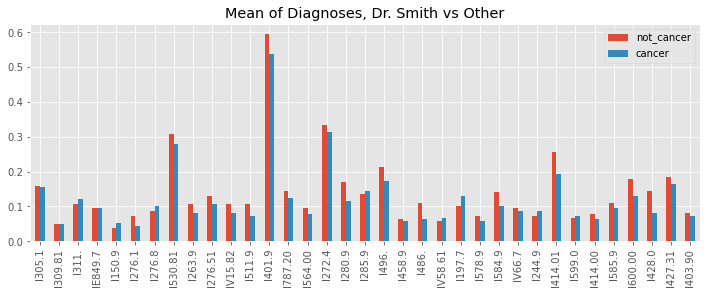

In [23]:
plt.style.use('ggplot')

_ = pd.DataFrame({
    'not_cancer': X.iloc[pair_df['y_0']].mean(),
    'cancer': X.iloc[pair_df['y_1']].mean()
}).plot(kind='bar', figsize=(12, 4), title='Mean of Diagnoses, Dr. Smith vs Other')

In [24]:
pair_df['y_0_dead'] = pair_df['y_0'].apply(lambda i: df.iloc[i]['Dead'])
pair_df['y_1_dead'] = pair_df['y_1'].apply(lambda i: df.iloc[i]['Dead'])
pair_df['diff'] = pair_df['y_1_dead'] - pair_df['y_0_dead']

pair_df['diff'].mean()

0.28502415458937197

### 2. Within the naturally occurring groups of diagnoses, calculate probability of cancer. 

In [25]:
import numpy as np

diagnosis_cols = [c for c in df.columns if c.startswith('I')]

prob_df = df[[c for c in df.columns if c not in ['Dead']]] \
    .dropna() \
    .groupby([c for c in df.columns if c not in ['Cancer', 'Dead']]) \
    .agg(['sum', 'count']) \
    .droplevel(0, axis=1) \
    .reset_index() \
    .rename(columns={'sum': 'cancer', 'count': 'n'}) \
    .query('cancer > 0') \
    .sort_values(['cancer'], ascending=[False])
prob_df['p_cancer'] = prob_df['cancer'] / prob_df['n']
prob_df['logit'] = prob_df['p_cancer'].apply(lambda p: np.log(p / (1 - p)) if p < 1.0 else np.log(0.99 / (1 - 0.99)))
prob_df['weight'] = prob_df['n'] / prob_df['n'].sum()

prob_df[list(prob_df.columns)[-5:]]

,cancer,n,p_cancer,logit,weight
0,13,14009,0.000928,-6.981577,0.447715
2244,4,12,0.333333,-0.693147,0.000384
7070,4,775,0.005161,-5.261394,0.024768
7384,3,685,0.004380,-5.426417,0.021892
2097,3,4366,0.000687,-7.282303,0.139533
...,...,...,...,...,...
5508,1,1,1.000000,4.595120,0.000032
5555,1,1,1.000000,4.595120,0.000032
5934,1,1,1.000000,4.595120,0.000032
6086,1,1,1.000000,4.595120,0.000032


In [26]:
from sklearn.linear_model import LinearRegression

X = prob_df[diagnosis_cols]
y = prob_df['logit']
w = prob_df['weight']

model = LinearRegression()
model.fit(X, y, sample_weight=w)

model.intercept_, model.coef_

(-7.029340213469109,
 array([ 0.50829167,  0.29046698,  1.05991731,  1.96675383,  3.86481627,
         2.70415213,  2.04024259,  1.28068554,  2.14857503,  1.48124871,
         1.72662315,  4.50785105, -0.16950004,  3.84992788,  2.462334  ,
         0.07672188,  2.98364663,  1.39040174,  1.09666235,  2.90165022,
        -0.45318779,  2.40590724,  4.22430548,  3.30569227,  0.9166009 ,
         2.99463998,  2.15796569,  0.86868328, -0.05785832,  2.13067872,
         4.2896719 ,  1.58215969,  1.89965765,  2.13228716, -1.35067072]))

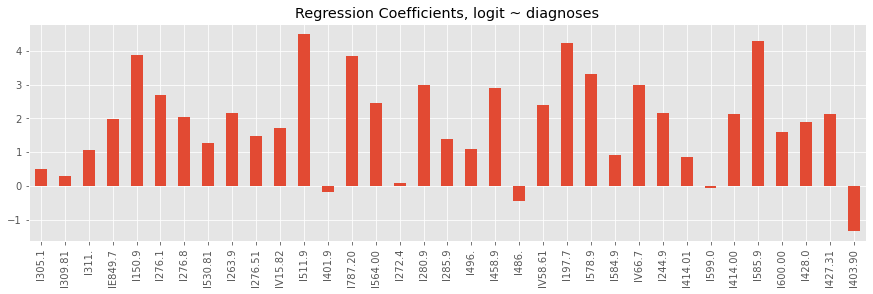

In [27]:
s2 = pd.Series(model.coef_, index=diagnosis_cols)
_ = s2.plot(kind='bar', figsize=(15, 4), title='Regression Coefficients, logit ~ diagnoses')

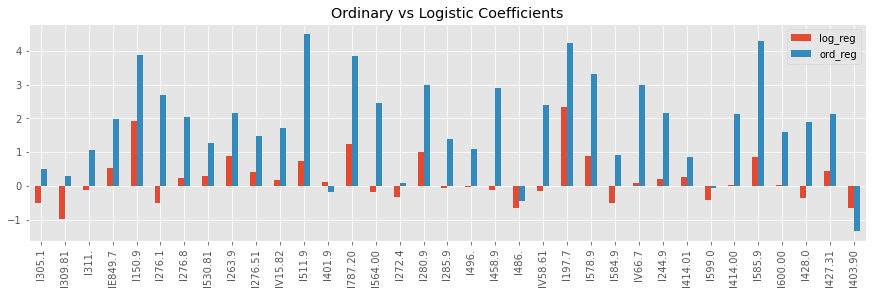

In [28]:
_ = pd.DataFrame({
    'log_reg': s1,
    'ord_reg': s2
}).plot(kind='bar', figsize=(15, 4), title='Ordinary vs Logistic Coefficients')